---
sidebar_position: 1
---

# Daily, Weekly and Yearly seasonalities.

A lot of signals have calendar based seasonalities:
- city noise levels have a **daily seasonality**: it's busy when people are out and calm at night.
- sales have a **weekly seasonality**: people buy more on Wednesdays and Saturdays.
- and for **yearly seasonality** ...you guessed it, seasons.

These seasonalities are hard to define with a simple mathematical function,
but most of the time you have a rough idea of their shape.
Let's see how you can create them with **mockseries** !


## Daily seasonality
Let's look at the [hourly energy consumption per household](https://www.researchgate.net/figure/Illustration-of-the-hourly-energy-consumption-of-different-appliances-per-household_fig1_290105581).
It's definitely cyclic: you consume less when you're sleeping, and there are pics corresponding to breakfast, lunch and dinner: things that happen everyday. 
![Hourly energy consumption per household](_files/seasonality-daily-weekly-yearly/hourly-energy-consumption-per-household.png)
To generate a similar signal in **mockseries**, we just need to identify a few `constraints` point: a time and its value.
An algorithm will then generate a realistic signal from the constraints. 
Times are expressed as `timedelta`s from the start of the period, so for [DailySeasonality](../API%20Reference/mockseries/seasonality/daily_seasonality), timedeltas should be between `0h 0min 0 sec` and `23h 59min 59.999sec`.   

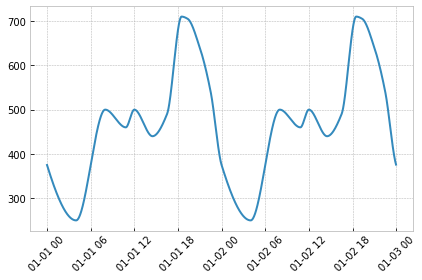

In [1]:
# plotting utilities for the whole tutorial 
import matplotlib.pyplot as plt
DEFAULT_SIZE_PLOT = plt.rcParamsDefault["figure.figsize"]
LARGE_SIZE_PLOT = (20,7)

from datetime import datetime, timedelta
from mockseries.seasonality import DailySeasonality

# create the daily seasonality signal 
constraints =  {
    timedelta(hours=0): 375,
    timedelta(hours=4): 250,
    timedelta(hours=8): 500,
    timedelta(hours=10, minutes=50): 460,
    timedelta(hours=12): 500,
    timedelta(hours=14, minutes=30): 440,
    timedelta(hours=16, minutes=30): 490,
    timedelta(hours=18, minutes=30): 710,
    timedelta(hours=18, minutes=30): 710,
    timedelta(hours=19, minutes=20): 705,
    timedelta(hours=21): 640,
    timedelta(hours=22, minutes=30): 540,
}
daily_seasonality = DailySeasonality(constraints)

# quick plotting on 2 days
daily_seasonality.preview_day(num_days=2, start_time=datetime(2021, 1, 1))

That's it ! [WeeklySeasonality](../API%20Reference/mockseries/seasonality/weekly_seasonality) and [YearlySeasonality](../API%20Reference/mockseries/seasonality/yearly_seasonality) work the same way, the 3 signals are subclasses of the [PeriodSeasonality](../API%20Reference/mockseries/seasonality/period_seasonality).
But don't leave just yet! We still have important features to explore.  

## Weekly seasonality - Managing timezone
Let's imagine the weekly traffic of an american social network: 
- the app has no users at night
- the app has many users around 7pm, except on Saturday and Sunday and 

Let's use [WeeklySeasonality](../API%20Reference/mockseries/seasonality/weekly_seasonality) to get this:

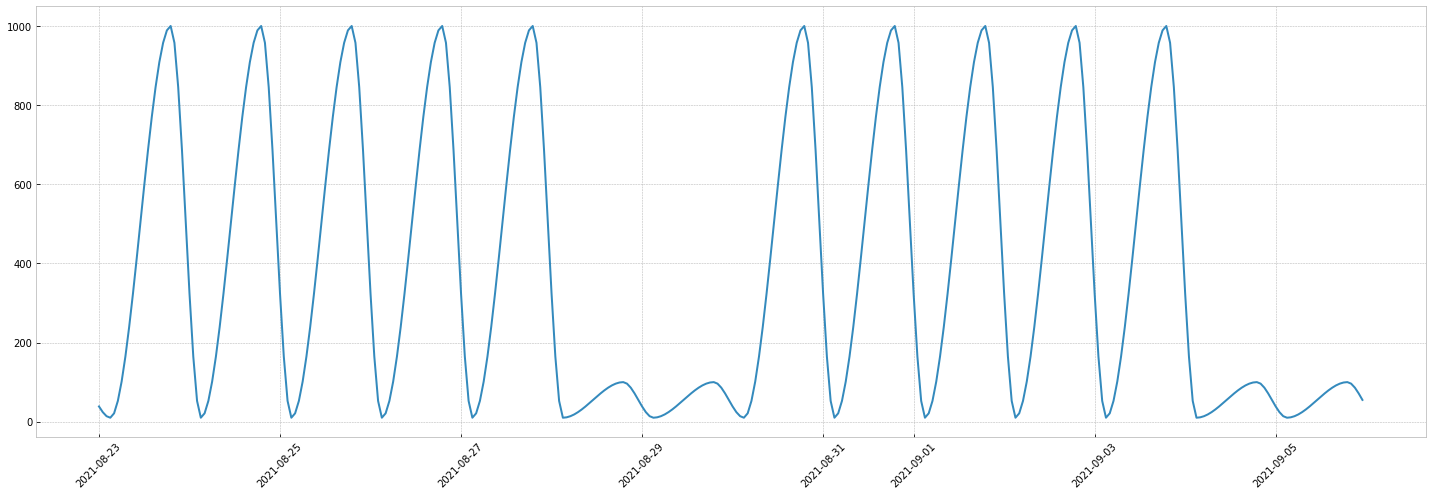

In [2]:
plt.rcParams["figure.figsize"] = LARGE_SIZE_PLOT
from mockseries.seasonality import WeeklySeasonality

constraints =  {
    timedelta(hours=3): 10,            ### EARLY MONDAY
    timedelta(days=1, hours=3): 10,    ### EARLY TUESDAY
    timedelta(days=2, hours=3): 10,    ### EARLY WEDNESDAY
    timedelta(days=3, hours=3): 10,    ### EARLY THURSDAY
    timedelta(days=4, hours=3): 10,    ### EARLY FRIDAY
    timedelta(days=5, hours=3): 10,    ### EARLY SATURDAY
    timedelta(days=6, hours=3): 10,    ### EARLY SUNDAY
    timedelta(hours=19): 1000,         ### MONDAY EVENING
    timedelta(days=1, hours=19): 1000, ### TUESDAY EVENING
    timedelta(days=2, hours=19): 1000, ### WEDNESDAY EVENING
    timedelta(days=3, hours=19): 1000, ### THURSDAY EVENING
    timedelta(days=4, hours=19): 1000, ### FRIDAY EVENING
    timedelta(days=5, hours=19): 100,  ### SATURDAY EVENING
    timedelta(days=6, hours=19): 100,  ### SUNDAY EVENING
}
weekly_seasonality = WeeklySeasonality(constraints)
weekly_seasonality.preview_week(num_weeks=2, start_time=datetime(2021, 8, 23))

Looks nice, but there's one problem. The social network is *american*, straight from the Silicon Valley ! All times were given with PDT timezone in mind.  
It's easy to do this in **mockseries**: just pass the UTC offset of the timezone.
For instance: PDT is UTC-7: just pass an `utc_offset` of -7 hours.

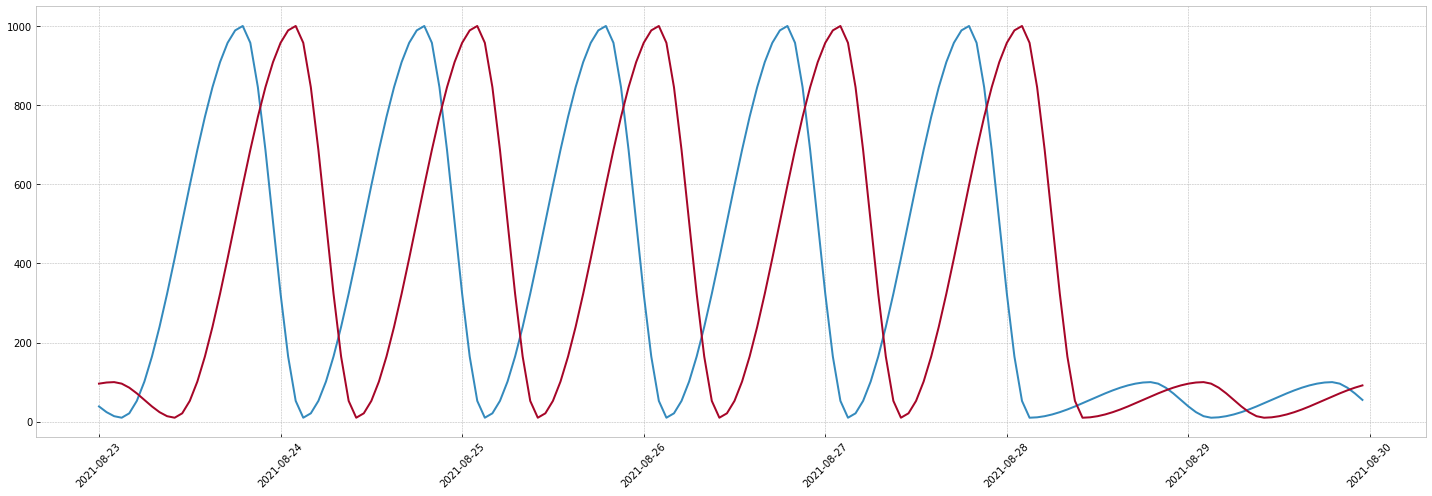

In [3]:
from mockseries.utils.dates import datetime_range
from mockseries.utils.plot import plot_timeseries

PDT_OFFSET = timedelta(hours=-7) 
weekly_seasonality = WeeklySeasonality(constraints)
weekly_seasonality_with_pdt_offset = WeeklySeasonality(constraints, utc_offset=PDT_OFFSET)

ts_index = datetime_range(
    granularity=timedelta(hours=1),
    start_time=datetime(2021, 8, 23),
    end_time=datetime(2021, 8, 23) + timedelta(days=7),
)

plot_timeseries(
    ts_index,
    [
        weekly_seasonality.generate(ts_index),
        weekly_seasonality_with_pdt_offset.generate(ts_index)
     ],
    titles=["UTC timezone", "PDT timezone"]
)


That's it! You can see the red curve corresponds to the PDT times.   
Of course this also works with the other seasonalities presented here.    

## Yearly seasonality - Normalizing
Let's have a look at the [Historical monthly average temperature in Croatia](https://climateknowledgeportal.worldbank.org/sites/default/files/2021-06/15847-WB_Croatia%20Country%20Profile-WEB_0.pdf) from the World Bank Group.

![yearly temperature seasonality](_files/seasonality-daily-weekly-yearly/yearly-temperatures-seasonality.png)

We have our pattern. It sounds reasonable to use the middle of a month to represent the average value of a month.
For instance:
- January: `timedelta(days=15)`
- February: `timedelta(days=46)`
- October: `timedelta(days=288)`.

Not easy to compute mentally, right ? Don't worry, middle-of-month timedeltas are available in the utils.
Also, because we're lazy, we won't fill the 12 months and let the algo generate a realistic curve.

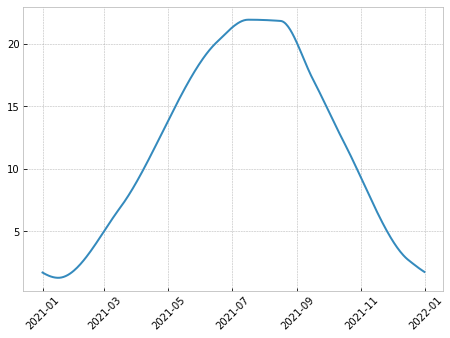

In [4]:
plt.rcParams["figure.figsize"] = DEFAULT_SIZE_PLOT
from mockseries.seasonality import YearlySeasonality
from mockseries.utils.timedeltas import JANUARY, MARCH, JUNE, JULY, AUGUST, SEPTEMBER, OCTOBER, DECEMBER

constraints = {
        JANUARY: 1.3,
        MARCH: 6.9,
        JUNE: 20.1,
        JULY: 21.9,
        AUGUST: 21.8,
        SEPTEMBER: 17.1,
        OCTOBER: 12,
        DECEMBER: 2.7,
    }
yearly_seasonality = YearlySeasonality(constraints)

yearly_seasonality.preview_year(start_time=datetime(2021, 1, 1))

Repeating on multiple years:

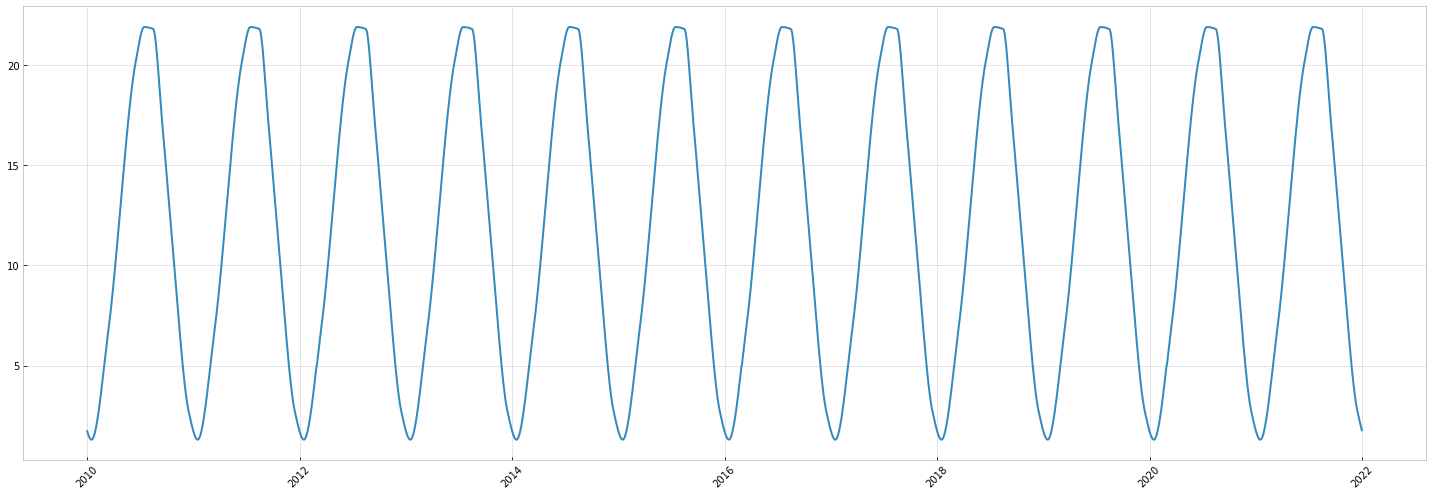

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = LARGE_SIZE_PLOT

yearly_seasonality.preview_year(num_years=12, start_time=datetime(2010, 1, 1))

That's nice, but let's make this more realistic now.
Look at the temperature trend:
![yearly temperature seasonality](_files/seasonality-daily-weekly-yearly/yearly-trend.png)
In 1980 temperature averaged 10.4 degrees. It was 12.6 in 2020.
We can roughly estimate that Croatia temperature follows a linear trend, raising by `(12.6-10.4)/10.4` --> `21.1%` in 40 years.
Something like:

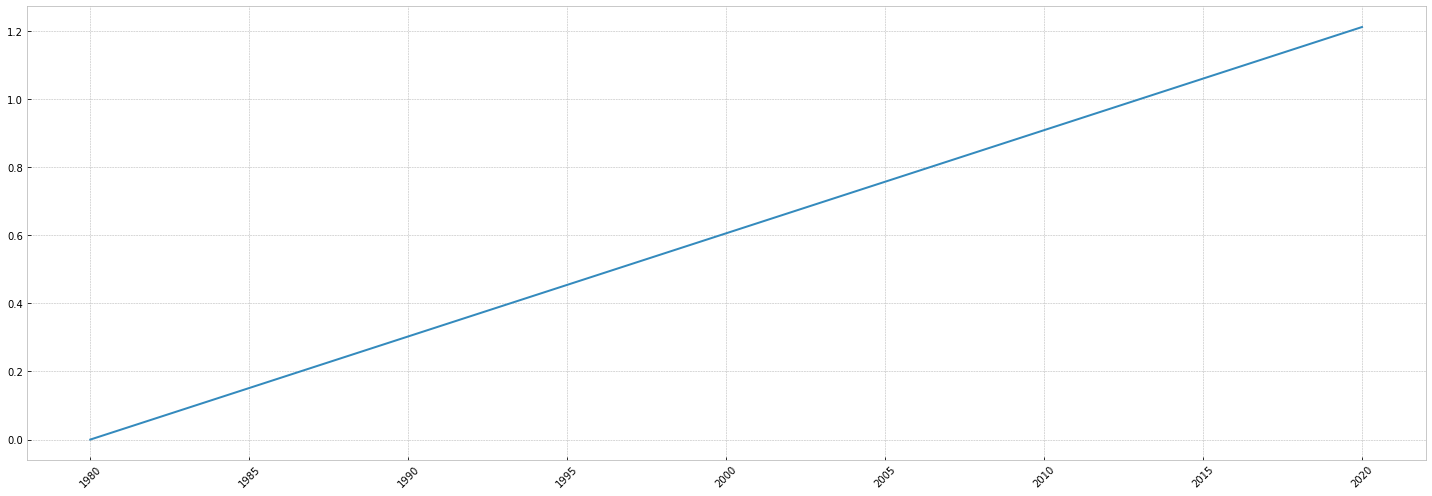

In [6]:
from mockseries.trend import LinearTrend

WARMING_COEFFICIENT = 1  + 0.211
PERIOD_YEARS = 40
trend = LinearTrend(coefficient=WARMING_COEFFICIENT,
                    time_unit=timedelta(days=365.25*PERIOD_YEARS),
                    )

# generate and plot
trend.preview_year(num_years=40, start_time=datetime(1980, 1, 1))

Let's combine this with our seasonality ! ... but how should we do this ?
Our [YearlySeasonality](../API%20Reference/mockseries/seasonality/yearly_seasonality) is based on *average* temperatures between 1990 and 2020.
We would have to somehow estimate the true values in 1990, and then estimate the values in 1980.
It's feasible with our linear trend  approximation, but  it's error prone.

Remember the [two types of interactions](interactions-article) ?
A simple way to get around this is to use `normalize` in our [YearlySeasonality](../API%20Reference/mockseries/seasonality/yearly_seasonality).
`normalize` transform constraints to a multiplication factor for easy use in multiplicative interactions.
Let's check it out:

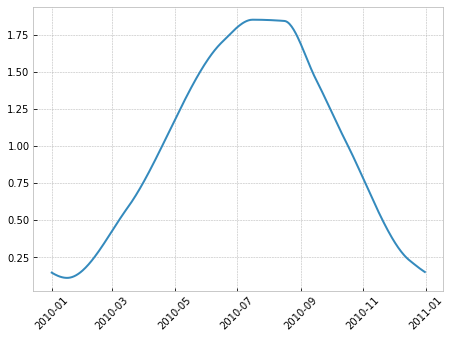

In [7]:
normalized_yearly_seasonality = YearlySeasonality(constraints, normalize=True)

plt.rcParams["figure.figsize"] = DEFAULT_SIZE_PLOT
normalized_yearly_seasonality.preview_year(start_time=datetime(2010, 1, 1))

Same curve, different scale.

Now it's easy to combine everything: we generate the base value, multiply it by our seasonality and add the trend.
Also, let's add a bit of noise to make this more realistic.

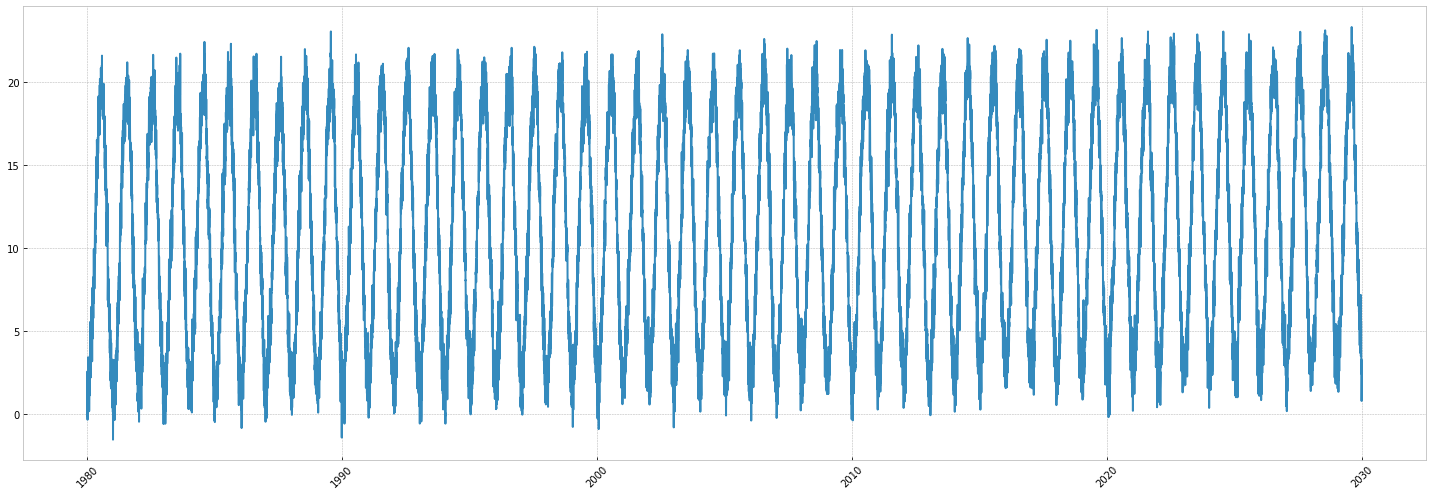

In [8]:
from mockseries.noise import RedNoise

noise = RedNoise(0,1)

#  combine signals - 10.4 is the value in 1980
timeseries = 10.4 * normalized_yearly_seasonality + trend + noise


# generate and plot for 20 years
plt.rcParams["figure.figsize"] = LARGE_SIZE_PLOT
timeseries.preview_year(num_years=50, start_time=datetime(1980, 1, 1))

Here you are: a simple temperature timeseries for Croatia.  
To go further, try to implement some improvements:

- Add the temperature's daily seasonality.
- Make the [YearlySeasonality](../API%20Reference/mockseries/seasonality/yearly_seasonality) multiplicative with the trend.
- Make the trend non linear, exponential maybe.

Go to the next page to learn how to create switches, and point in time events.  
Go directly to the [PeriodSeasonality's API Reference](../API%20Reference/mockseries/seasonality/period_seasonality) to see how to extend the PeriodSeasonality for your own custom period.
